In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialise random number generators.
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

###### Importing MNIST database

In [2]:
from keras.datasets import mnist

# Define the dimensions (in pixels) of the input images.
# Each pixel will correspond to a value of a matrix.
img_width = 28
img_height = 28

# Define the form of the output.
# The machine will try to classify the input in one of ten digits.
n_classes = 10

# Download the database
(in_training, out_training), (in_validation, out_validation) = mnist.load_data()

# Reshape the input data.
# The downloaded data may be modelled as a n_samples * img_width *
# * img_height array, but I need that each sample be a vector
# (i.e. just one line).
# x.shape[0] is the number of samples.
in_training = in_training.reshape(in_training.shape[0], img_width * img_height)
in_validation = in_validation.reshape(in_validation.shape[0], img_width * img_height)

# MNIST gives data as integers from 0 to 255 (= grayscale level of the pixel).
# I need it to be a value between 0 and 1, so I will rescale it.
in_training = in_training.astype("float32")
in_validation = in_validation.astype("float32")
in_training /= 255
in_validation /= 255

# The output will be a 10-entries vector, each value representing the probability
# that the corresponding digit is the correct one.
# The output data needs to be "converted" in this format.
out_training = keras.utils.to_categorical(out_training, n_classes)
out_validation = keras.utils.to_categorical(out_validation, n_classes)

Using TensorFlow backend.


###### Definition of the neural network

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, Adadelta

# Define some networks using different optimizers.
# The inner structure of each model will be the same.
models = {
    "sgd": Sequential(),
    "adadelta" : Sequential(),
    "adam": Sequential()
}

for optimizer, model in models.items():
    # Input layer: it must contain as much neurons as the number of inputs.
    model.add(Dense(
        400,
        input_shape = (img_width * img_height,),
        activation = "relu"
    ))
    
    # Middle layers
    model.add(Dense(
        100,
        activation = "relu"
    ))
    model.add(Dropout(0.5))
    
    # Output layer: use the softmax activation function to convert the
    # input in a probability value.
    model.add(Dense(
        n_classes,
        activation = "softmax"
    ))

###### Network training

In [4]:
batch_size = 32
n_epochs = 5

for optimizer, model in models.items():
    model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = optimizer,
        metrics = ["accuracy"]
    )

# As the training advances, save the progress of the validation
# in the "history" object.
history = {}
for key, model in models.items():
    history[key] = models[key].fit(
        in_training,
        out_training,
        batch_size = batch_size,
        epochs = n_epochs,
        verbose = 1,
        validation_data = (in_validation, out_validation)
    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 18s 299us/step - loss: 0.7560 - acc: 0.7771 - val_loss: 0.3104 - val_acc: 0.9174
Epoch 2/5
60000/60000 [==============================] - 11s 181us/step - loss: 0.3850 - acc: 0.8907 - val_loss: 0.2379 - val_acc: 0.9327
Epoch 3/5
60000/60000 [==============================] - 10s 172us/step - loss: 0.3112 - acc: 0.9117 - val_loss: 0.2025 - val_acc: 0.9410
Epoch 4/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.2674 - acc: 0.9243 - val_loss: 0.1739 - val_acc: 0.9491
Epoch 5/5
60000/60000 [==============================] - 11s 186us/step - loss: 0.2360 - acc: 0.9338 - val_loss: 0.1554 - val_acc: 0.9548
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 317us/step - loss: 0.3170 - acc: 0.9068 - val_loss: 0.1225 - val_acc: 0.9640
Epoch 2/5
60000/60000 [==============================] - 18s 308us/step 

###### Evaluation results

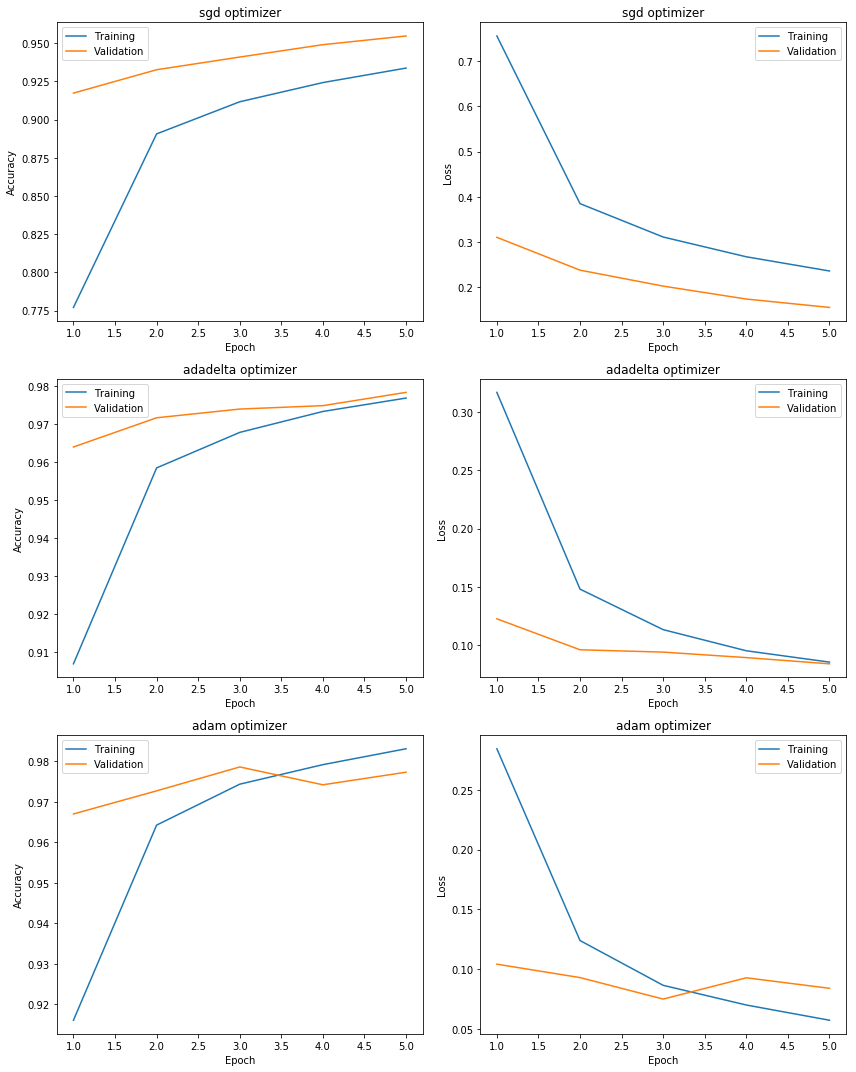

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 15))
axes = axes.flatten()
epochs_range = range(1, n_epochs + 1)

for i, (optimizer, model_history) in zip(range(len(history)), history.items()):
    axes[2 * i].set_xlabel("Epoch")
    axes[2 * i].set_ylabel("Accuracy")
    axes[2 * i].set_title(optimizer + " optimizer")
    axes[2 * i].plot(epochs_range, model_history.history["acc"])
    axes[2 * i].plot(epochs_range, model_history.history["val_acc"])
    axes[2 * i].legend(["Training", "Validation"])
    
    axes[2 * i + 1].set_xlabel("Epoch")
    axes[2 * i + 1].set_ylabel("Loss")
    axes[2 * i + 1].set_title(optimizer + " optimizer")
    axes[2 * i + 1].plot(epochs_range, model_history.history["loss"])
    axes[2 * i + 1].plot(epochs_range, model_history.history["val_loss"])
    axes[2 * i + 1].legend(["Training", "Validation"])

fig.tight_layout()
plt.show()

###### Predictions
Now that the network is trained, it can be used to guess some digits.

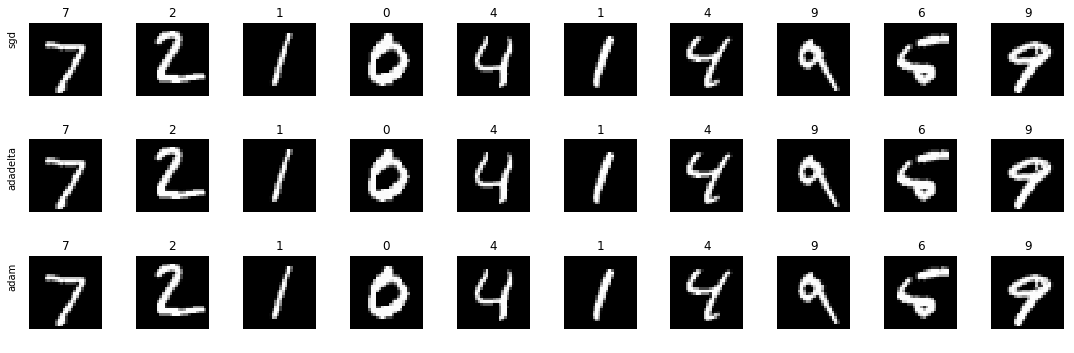

In [6]:
test = in_validation.reshape(in_validation.shape[0], img_width, img_height, 1) #?

fig, axes = plt.subplots(nrows = 3, ncols = 10, figsize = (15, 5))
axes = axes.flatten()

for j, (optimizer, model) in zip(range(len(models)), models.items()):
    prediction = model.predict(in_validation)
    for i in range(10):
        axes[10 * j + i].imshow(test[i, :, :, 0], cmap = "gray")
        axes[10 * j + i].set_title(np.argmax(prediction[i]))
        axes[10 * j + i].axis("off")
    axes[10 * j].text(
        -5,
        5,
        optimizer,
        horizontalalignment='right',
        rotation = 90
    )

fig.tight_layout()
plt.show()

###### Comments
The network using the *adadelta* optimizer is the only one which guessed correctly these last ten digits (I believe the second to last is a 5), but I admit that this is too little a sample to judge the performance on this alone.
The accuracy level shown in the plots up above confirms this result, showing that the *adadelta* network has better validation and training accuracy levels.